In [1]:
# Imports
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import kagglehub
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
!pip install kaggle

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105797 sha256=18e9eee36a5b787bbe266abf5705f907bdd0d1062985f0b62a881842f004094f
  Stored in directory: c:\users\iamsh\appdata\local\pip\cache\wheels\46\d2\26\84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle


In [4]:
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Create a sample dataset for development
sample_data = {
    'title': [
        'Tech Company Launches New Product',
        'Political Summit in Europe',
        'Sports Team Wins Championship'
    ],
    'text': [
        'Apple Inc. announced their latest iPhone today in California. CEO Tim Cook presented the new features.',
        'Leaders from France and Germany met in Berlin to discuss EU policies. Emmanuel Macron and Olaf Scholz attended.',
        'The Golden State Warriors won the NBA championship. Stephen Curry scored 30 points in the final game.'
    ]
}

# Create DataFrame
df = pd.DataFrame(sample_data)

print("Sample Dataset Created:")
print(f"Number of articles: {len(df)}")
print("\nSample article:")
print(df.iloc[0])

Sample Dataset Created:
Number of articles: 3

Sample article:
title                    Tech Company Launches New Product
text     Apple Inc. announced their latest iPhone today...
Name: 0, dtype: object


In [5]:
# Text Preprocessing
def clean_text(text):
    """Clean and normalize text"""
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase and remove extra whitespace
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    
    return text

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Show results
print("Original vs Cleaned Text:")
for i in range(len(df)):
    print(f"\nArticle {i+1}:")
    print("Original:", df['text'][i][:100], "...")
    print("Cleaned:", df['cleaned_text'][i][:100], "...")

Original vs Cleaned Text:

Article 1:
Original: Apple Inc. announced their latest iPhone today in California. CEO Tim Cook presented the new feature ...
Cleaned: apple inc announced their latest iphone today in california ceo tim cook presented the new features ...

Article 2:
Original: Leaders from France and Germany met in Berlin to discuss EU policies. Emmanuel Macron and Olaf Schol ...
Cleaned: leaders from france and germany met in berlin to discuss eu policies emmanuel macron and olaf scholz ...

Article 3:
Original: The Golden State Warriors won the NBA championship. Stephen Curry scored 30 points in the final game ...
Cleaned: the golden state warriors won the nba championship stephen curry scored 30 points in the final game ...


In [6]:
import pandas as pd
import os
from pathlib import Path


def find_dataset():
    """Find the dataset file in the data directory"""
    # Common paths to check
    possible_paths = [
        './data/raw/',
        './data/',
        '../data/',
        '../data/raw/',
        'C:/Users/iamsh/OneDrive/Desktop/NER/news_analysis_project/data/raw/',
        'C:/Users/iamsh/OneDrive/Desktop/NER/news_analysis_project/data/'
    ]
    
    print("Searching for dataset...")
    for path in possible_paths:
        path = Path(path)
        if path.exists():
            print(f"\nChecking directory: {path}")
            files = list(path.glob('*'))
            print("Files found:", [f.name for f in files])
            
            # Look specifically for CSV files
            csv_files = list(path.glob('*.csv'))
            if csv_files:
                print(f"\nFound CSV files: {[f.name for f in csv_files]}")
                return csv_files[0]
    
    return None

# Try to find and load the dataset
dataset_path = find_dataset()

if dataset_path is not None:
    print(f"\nLoading dataset from: {dataset_path}")
    try:
        df = pd.read_csv(dataset_path)
        print("\nDataset loaded successfully!")
        print(f"Number of articles: {len(df)}")
        print("\nColumns:", df.columns.tolist())
        print("\nFirst few rows:")
        print(df.head())
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
else:
    print("\nNo dataset found. Please ensure the news articles CSV file is in the data/raw directory.")

Searching for dataset...

Checking directory: data\raw
Files found: []

Checking directory: data
Files found: ['processed', 'rae', 'raw']

Checking directory: C:\Users\iamsh\OneDrive\Desktop\NER\news_analysis_project\data\raw
Files found: ['news-articles-corpus.zip', 'news_articles.csv']

Found CSV files: ['news_articles.csv']

Loading dataset from: C:\Users\iamsh\OneDrive\Desktop\NER\news_analysis_project\data\raw\news_articles.csv
Error loading dataset: No columns to parse from file


In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

# Set the path to the dataset
dataset_path = Path(r"C:\Users\iamsh\.cache\kagglehub\datasets\sbhatti\news-articles-corpus\versions\1\data")

def read_article(file_path):
    """Read a single article file and return its content"""
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# Get list of all text files
text_files = list(dataset_path.glob('article_*.txt'))
print(f"Found {len(text_files)} article files")

# Create a list to store articles
articles = []

# Read first 1000 articles (for testing - we can increase this later)
for file_path in text_files[:1000]:
    try:
        content = read_article(file_path)
        articles.append({
            'file_name': file_path.name,
            'text': content
        })
    except Exception as e:
        print(f"Error reading {file_path.name}: {str(e)}")

# Convert to DataFrame
df = pd.DataFrame(articles)

print("\nDataset created successfully!")
print(f"Number of articles loaded: {len(df)}")
print("\nFirst article preview:")
print(df['text'].iloc[0][:500], "...\n")

# Basic statistics
print("\nBasic Statistics:")
print(f"Average article length (characters): {df['text'].str.len().mean():.2f}")
print(f"Shortest article length: {df['text'].str.len().min()}")
print(f"Longest article length: {df['text'].str.len().max()}")

# Save to CSV for future use
output_path = Path('./data/raw/processed_articles.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)
print(f"\nDataset saved to: {output_path}")

Found 870521 article files

Dataset created successfully!
Number of articles loaded: 1000

First article preview:
New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says  ...


Basic Statistics:
Average article length (characters): 4319.96
Shortest article length: 46
Longest article length: 330704

Dataset saved to: data\raw\processed_articles.csv


In [10]:
# Text preprocessing and NER
import spacy
import re

def clean_text(text):
    """Clean and normalize text"""
    # Remove special characters and extra whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Process a sample article
sample_text = df['text'].iloc[0]
print("Sample Article Analysis:")
print("-" * 50)
print("Original text preview:")
print(sample_text[:200], "...\n")

# Clean text
cleaned_text = clean_text(sample_text)
print("Cleaned text preview:")
print(cleaned_text[:200], "...\n")

# Extract entities
doc = nlp(sample_text)
print("Named Entities found:")
for ent in doc.ents:
    print(f"- {ent.text} ({ent.label_})")

Sample Article Analysis:
--------------------------------------------------
Original text preview:
New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but th ...

Cleaned text preview:
new york police are concerned drones could become tools for terrorists and are investigating ways to stop potential attacks until now police haven t acknowledged drones as a potential weapon but the n ...

Named Entities found:
- New York (GPE)
- NYPD (ORG)
- NYPD (ORG)
- one (CARDINAL)
- Salvatore DiPace (PERSON)
- last year (DATE)
- German (NORP)
- Angela Merkel (PERSON)
- Manchester (GPE)
- England (GPE)
- a week ago (DATE)
- NYPD (ORG)
- the last year (DATE)
- Salvatore DiPace (PERSON)
- CBS News (ORG)
- Dipace (PERSON)
- NYPD (ORG)
- one (CARDINAL)
- DiPace (PERSON)
- Germany (GPE)
- last year (DATE)
- German (NORP)
- Angela Merkel (PERSON)
- Ms Merkel (PERSON

In [16]:
import pandas as pd
from pathlib import Path
import spacy
from collections import Counter

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Redefine dataset and `df` if not already defined
dataset_path = Path(r"C:\Users\iamsh\.cache\kagglehub\datasets\sbhatti\news-articles-corpus\versions\1\data")
text_files = list(dataset_path.glob('article_*.txt'))

def read_article(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

articles = []
for file_path in text_files[:1000]:
    try:
        content = read_article(file_path)
        articles.append({'file_name': file_path.name, 'text': content})
    except Exception as e:
        print(f"Error reading {file_path.name}: {e}")

df = pd.DataFrame(articles)

# Define entity extraction function
def count_entity_types(text):
    doc = nlp(text)
    entity_counts = Counter([ent.label_ for ent in doc.ents])
    return dict(entity_counts)

# Apply function to DataFrame
df['entity_counts'] = df['text'].apply(count_entity_types)

# Aggregate entity counts for all articles
all_entity_counts = Counter()
for counts in df['entity_counts']:
    all_entity_counts.update(counts)

print("Entity Frequency Across Articles:", all_entity_counts)


Entity Frequency Across Articles: Counter({'PERSON': 17795, 'ORG': 12662, 'DATE': 10645, 'GPE': 9654, 'CARDINAL': 7518, 'NORP': 3194, 'TIME': 1608, 'ORDINAL': 1514, 'MONEY': 1117, 'LOC': 933, 'FAC': 760, 'WORK_OF_ART': 621, 'QUANTITY': 595, 'EVENT': 390, 'PRODUCT': 341, 'PERCENT': 257, 'LAW': 245, 'LANGUAGE': 95})


In [20]:
df['word_count'] = df['text'].str.split().str.len()
df['char_count'] = df['text'].str.len()


In [21]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Polarity ranges from -1 (negative) to 1 (positive)

df['sentiment'] = df['text'].apply(get_sentiment)


In [22]:
features_df = pd.DataFrame({
    'file_name': df['file_name'],
    'word_count': df['word_count'],
    'char_count': df['char_count'],
    'sentiment': df['sentiment'],
})

# Add entity counts as separate columns
entity_types = list(all_entity_counts.keys())
for entity in entity_types:
    features_df[entity] = df['entity_counts'].apply(lambda x: x.get(entity, 0))

print(features_df.head())


            file_name  word_count  char_count  sentiment  GPE  ORG  CARDINAL  \
0  article_000000.txt         495        2906   0.110032    6    6         4   
1  article_000001.txt         270        1612  -0.211111    2    8         0   
2  article_000002.txt        1019        5515   0.171224    2   15        27   
3  article_000003.txt         592        3666   0.058609   13   10         5   
4  article_000004.txt         556        3255   0.043783   16   10         8   

   PERSON  DATE  NORP  ...  TIME  EVENT  PRODUCT  LOC  FAC  WORK_OF_ART  \
0       8     6     2  ...     0      0        0    0    0            0   
1       5     1     2  ...     0      0        0    0    0            0   
2      29    22     5  ...     2      3        1    1    0            0   
3       3     4     5  ...     1      0        0    4    1            0   
4       7     7     0  ...     9      0        0    0    0            0   

   LANGUAGE  MONEY  LAW  PERCENT  
0         0      0    0        0 

In [24]:
print(df.columns)
#to check the columns in the dataset

Index(['file_name', 'text', 'entity_counts', 'sentiment', 'word_count',
       'char_count'],
      dtype='object')


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = features_df.drop(['file_name'], axis=1)
y = df['word_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("MAE:", mean_absolute_error(y_test, y_pred))

MAE: 11.845450000000001


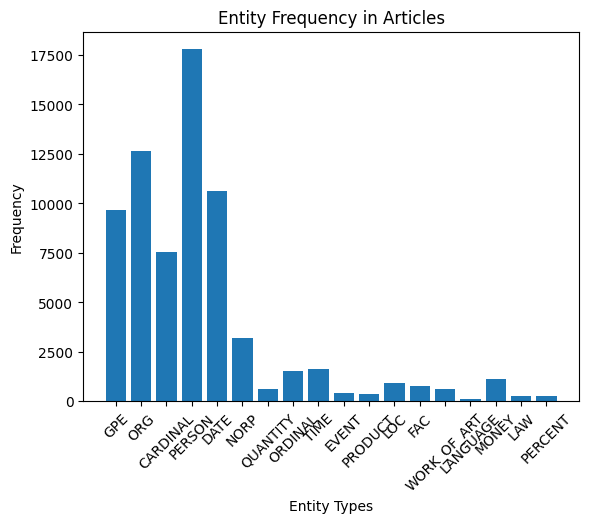

In [30]:
import matplotlib.pyplot as plt

entity_labels, entity_freq = zip(*all_entity_counts.items())
plt.bar(entity_labels, entity_freq)
plt.xlabel('Entity Types')
plt.ylabel('Frequency')
plt.title('Entity Frequency in Articles')
plt.xticks(rotation=45)
plt.show()


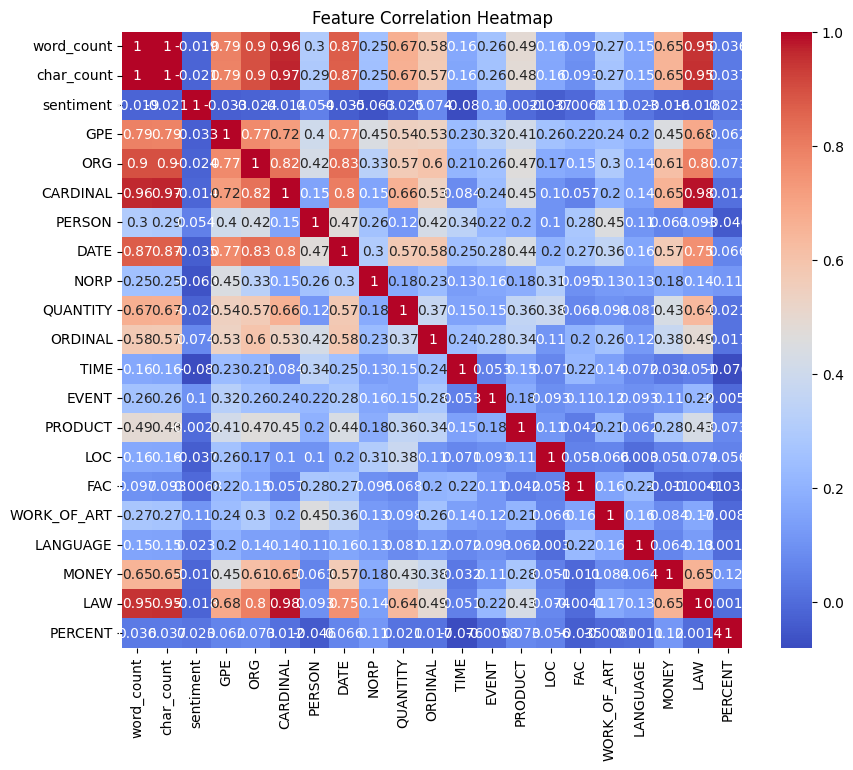

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_columns = features_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_columns.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()
